# Congressional Record and Hansard Word Embeddings Analysis


## Setup


In [86]:
import os
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

DATA_PATH = 'data/'
DIST_PATH = 'dist/'

EMBEDDINGS_PATH = '../../glove-embeddings/'

if not os.path.exists(DIST_PATH):
    os.makedirs(DIST_PATH)

tqdm.pandas()
plt.style.use('ggplot')

## Generating word embeddings


### Functions for GloVe embeddings


In [2]:
word_vectors = KeyedVectors.load_word2vec_format(
    f'{EMBEDDINGS_PATH}glove.840B.300d.txt', binary=False, no_header=True)

In [5]:
def get_weighted_embedding(doc, tokens_column, word_vectors, tfidf_matrix, feature_names):
    doc_tokens = doc[tokens_column].split()
    doc_embedding = np.zeros(word_vectors.vector_size)

    # Get the document index in the TF-IDF matrix
    doc_index = doc.name

    # Get the column indices and values for the current document in the TF-IDF matrix
    col_indices = tfidf_matrix[doc_index].indices
    tfidf_scores = tfidf_matrix[doc_index].data

    # Create a dictionary of token to TF-IDF score for the current document
    tfidf_dict = {feature_names[col_index]: score for col_index, score in zip(
        col_indices, tfidf_scores)}

    # Calculate the weighted embedding by summing the product of word vectors and TF-IDF scores
    weighted_vectors = [word_vectors[token] * tfidf_dict.get(
        token, 0) for token in doc_tokens if token in word_vectors.key_to_index]
    if weighted_vectors:
        doc_embedding = sum(weighted_vectors)

    # Normalize by dividing by the number of words in the sentence
    if len(doc_tokens) > 0:
        doc_embedding /= len(doc_tokens)

    return doc_embedding


def generate_weighted_embeddings(corpus_df, tokens_column, word_vectors):
    # Create a TF-IDF vectorizer and calculate the TF-IDF matrix
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_df[tokens_column])

    # Convert the TF-IDF matrix to a compressed sparse row matrix for efficient row-wise access
    tfidf_matrix_csr = csr_matrix(tfidf_matrix)

    # Get the feature names (tokens) from the vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    tqdm.pandas(desc="Generating weighted embeddings")
    corpus_df['weighted_embedding'] = corpus_df.progress_apply(
        lambda doc: get_weighted_embedding(
            doc, tokens_column, word_vectors, tfidf_matrix_csr, feature_names),
        axis=1
    )

    return corpus_df

### Embedding the Congressional Record and Hansard


**Embedding the Congressional Record**


In [8]:
congressional_record = pd.read_csv(
    DATA_PATH + 'non_procedural_congressional_record.csv')

congressional_record_embeddings = generate_weighted_embeddings(
    congressional_record, 'cleaned_tokens', word_vectors)

congressional_record_embeddings.to_parquet(
    DATA_PATH + 'congressional_record_embeddings.parquet')

del congressional_record
del congressional_record_embeddings

Generating weighted embeddings: 100%|██████████| 478172/478172 [03:03<00:00, 2606.02it/s]


**Embedding Hansard**


In [10]:
hansard = pd.read_csv(DATA_PATH + 'non_procedural_hansard.csv')

hansard_embeddings = generate_weighted_embeddings(
    hansard, 'cleaned_tokens', word_vectors)

hansard_embeddings.to_parquet(DATA_PATH + 'hansard_embeddings.parquet')

del hansard
del hansard_embeddings

Generating weighted embeddings: 100%|██████████| 448828/448828 [01:03<00:00, 7037.35it/s] 


### Embedding the Climate Congressional Record and Climate Hansard


**Embedding the Climate Congressional Record**


In [6]:
climate_congressional_record = pd.read_csv(
    DATA_PATH + 'climate_congressional_record.csv')

climate_congressional_record_embeddings = generate_weighted_embeddings(
    climate_congressional_record, 'cleaned_tokens', word_vectors)

climate_congressional_record_embeddings.to_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')

del climate_congressional_record
del climate_congressional_record_embeddings

Generating weighted embeddings: 100%|██████████| 27043/27043 [00:08<00:00, 3094.82it/s]


**Embedding Climate Hansard**


In [7]:
climate_hansard = pd.read_csv(DATA_PATH + 'climate_hansard.csv')

climate_hansard_embeddings = generate_weighted_embeddings(
    climate_hansard, 'cleaned_tokens', word_vectors)

climate_hansard_embeddings.to_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

del climate_hansard
del climate_hansard_embeddings

Generating weighted embeddings: 100%|██████████| 25510/25510 [00:03<00:00, 8361.25it/s]


## Time series analysis


In [9]:
congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'congressional_record_embeddings.parquet')
hansard_embeddings = pd.read_parquet(DATA_PATH + 'hansard_embeddings.parquet')

climate_congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')
climate_hansard_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

### Calculating the monthly average cosine similarities of Climate Congressional Record and Climate Hansard embeddings


**Functions**


In [11]:
def process_month(month_group, party_1, party_2, party_column, prefix):
    # Filter speeches by party
    party_1_group = month_group[month_group[party_column] ==
                                party_1]['weighted_embedding'].tolist()
    party_2_group = month_group[month_group[party_column] ==
                                party_2]['weighted_embedding'].tolist()

    if not party_1_group or not party_2_group:
        return pd.Series({
            f'{prefix}_average_similarity': np.nan,
            f'{prefix}_std_dev_similarity': np.nan,
            f'{prefix}_num_comparisons': 0,
            f'{prefix}_confidence_interval': np.nan,
            f'{prefix}_upper_bound': np.nan,
            f'{prefix}_lower_bound': np.nan
        })

    # Calculate cosine similarities between the speeches in the two groups
    similarity_matrix = cosine_similarity(party_1_group, party_2_group)
    average_similarity = np.mean(similarity_matrix)
    std_dev_similarity = np.std(similarity_matrix)
    num_comparisons = similarity_matrix.size
    confidence_interval = 1.96 * \
        (std_dev_similarity / np.sqrt(num_comparisons))  # 95% confidence interval

    return pd.Series({
        f'{prefix}_average_similarity': average_similarity,
        f'{prefix}_std_dev_similarity': std_dev_similarity,
        f'{prefix}_num_comparisons': num_comparisons,
        f'{prefix}_confidence_interval': confidence_interval,
        f'{prefix}_upper_bound': average_similarity + confidence_interval,
        f'{prefix}_lower_bound': average_similarity - confidence_interval
    })

**Calculating monthly average cosine similarities for climate corpora**


In [23]:
climate_congressional_record_embeddings['year_month'] = pd.to_datetime(
    climate_congressional_record_embeddings['date']).dt.to_period('M')
climate_congressional_record_embeddings.sort_values('year_month', inplace=True)

climate_hansard_embeddings['year_month'] = pd.to_datetime(
    climate_hansard_embeddings['speech_date']).dt.to_period('M')
climate_hansard_embeddings.sort_values('year_month', inplace=True)

climate_congressional_record_similarities = climate_congressional_record_embeddings.groupby(
    'year_month').progress_apply(
    lambda month_group: process_month(
        month_group, 'R', 'D', 'party', 'climate_congressional_record')
)
climate_congressional_record_similarities = climate_congressional_record_similarities[
    climate_congressional_record_similarities['climate_congressional_record_num_comparisons'] > 20]

climate_hansard_similarities = climate_hansard_embeddings.groupby(
    'year_month').progress_apply(
    lambda month_group: process_month(
        month_group, 'Conservative', 'Labour', 'speech_party', 'climate_hansard')
)
climate_hansard_similarities = climate_hansard_similarities[
    climate_hansard_similarities['climate_hansard_num_comparisons'] > 20]

Generating weighted embeddings:   0%|          | 0/217 [00:00<?, ?it/s]

Generating weighted embeddings: 100%|██████████| 199/199 [00:00<00:00, 371.74it/s]


**Creating a dataframe to store the climate corpora's monthly average cosine similarities**


In [31]:
all_dates = pd.date_range(
    start=climate_hansard_embeddings['year_month'].min(
    ).to_timestamp(),
    end=climate_hansard_embeddings['year_month'].max(
    ).to_timestamp(),
    freq='M'
)
all_dates = all_dates.to_period('M')

climate_monthly_similarities = pd.DataFrame(index=all_dates)

climate_monthly_similarities = climate_monthly_similarities.join(
    climate_congressional_record_similarities)
climate_monthly_similarities = climate_monthly_similarities.join(
    climate_hansard_similarities)

climate_monthly_similarities = climate_monthly_similarities.interpolate(
    method='time').dropna()

### Plotting the monthly average cosine similarities of Climate Congressional Record and Climate Hansard embeddings


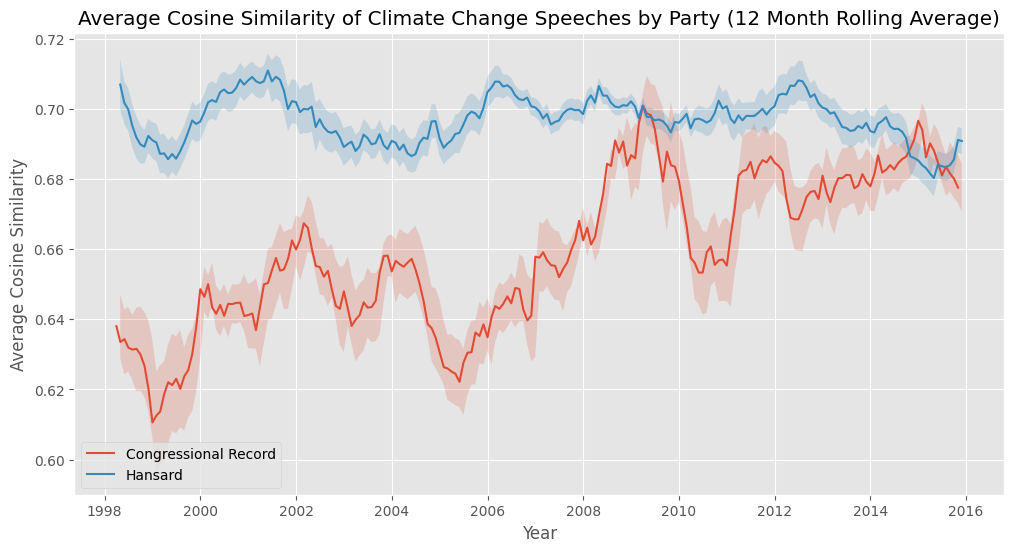

In [40]:
widow = 12

plt.figure(figsize=(12, 6))
plt.plot(climate_monthly_similarities.index.to_timestamp(), climate_monthly_similarities['climate_congressional_record_average_similarity'].rolling(
    window=widow).mean(), label='Congressional Record')
plt.fill_between(climate_monthly_similarities.index, climate_monthly_similarities['climate_congressional_record_lower_bound'].rolling(
    window=widow).mean(), climate_monthly_similarities['climate_congressional_record_upper_bound'].rolling(window=widow).mean(), alpha=0.2)

plt.plot(climate_monthly_similarities.index, climate_monthly_similarities['climate_hansard_average_similarity'].rolling(
    window=widow).mean(), label='Hansard')
plt.fill_between(climate_monthly_similarities.index, climate_monthly_similarities['climate_hansard_lower_bound'].rolling(
    window=widow).mean(), climate_monthly_similarities['climate_hansard_upper_bound'].rolling(window=widow).mean(), alpha=0.2)

plt.title('Average Cosine Similarity of Climate Change Speeches by Party (12 Month Rolling Average)')
plt.xlabel('Year')
plt.ylabel('Average Cosine Similarity')
plt.legend()

## Validation


In [60]:
climate_congressional_record_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_congressional_record_embeddings.parquet')
climate_hansard_embeddings = pd.read_parquet(
    DATA_PATH + 'climate_hansard_embeddings.parquet')

### Investigating the most dissimilar speeches in three randomly selected months of the Climate Congressional Record and Climate Hansard


**Functions**


In [109]:
def find_most_dissimilar_speeches(month_group, party_1, party_2, speaker_column, date_column, text_column,  party_column):
    # Filter speeches by party
    party_1_group = month_group[month_group[party_column] == party_1]
    party_2_group = month_group[month_group[party_column] == party_2]

    if party_1_group.empty or party_2_group.empty:
        return pd.DataFrame()

    # Calculate cosine similarities between the speeches in the two groups
    similarity_matrix = cosine_similarity(
        party_1_group['weighted_embedding'].tolist(),
        party_2_group['weighted_embedding'].tolist()
    )

    # Find the indexes of the 2 smallest values
    min_similarity_indexes = np.unravel_index(
        np.argsort(similarity_matrix, axis=None)[:2], similarity_matrix.shape)

    party_1_speech_indexes = party_1_group.index[min_similarity_indexes[0]].tolist(
    )
    party_2_speech_indexes = party_2_group.index[min_similarity_indexes[1]].tolist(
    )
    min_similarities = similarity_matrix[min_similarity_indexes]

    # Select the speeches and metadata for the most dissimilar pairs
    party_1_speeches = party_1_group.loc[party_1_speech_indexes]
    party_2_speeches = party_2_group.loc[party_2_speech_indexes]

    # Rename the columns to reflect the party association
    party_1_speeches.rename(columns={
        speaker_column: 'party_1_name',
        date_column: 'party_1_speech_date',
        text_column: 'party_1_text',
        party_column: 'party_1_party'
    }, inplace=True)
    party_2_speeches.rename(columns={
        speaker_column: 'party_2_name',
        date_column: 'party_2_speech_date',
        text_column: 'party_2_text',
        party_column: 'party_2_party'
    }, inplace=True)

    # Concatenate the DataFrames and add the similarity scores
    dissimilar_speeches_df = pd.concat([
        party_1_speeches.reset_index(drop=True)[
            ['party_1_name', 'party_1_speech_date', 'party_1_text', 'party_1_party']],
        party_2_speeches.reset_index(drop=True)[
            ['party_2_name', 'party_2_speech_date', 'party_2_text', 'party_2_party']],
        pd.Series(min_similarities, name='similarity')
    ], axis=1).reset_index(drop=True)

    return dissimilar_speeches_df

**Randomly selecting three months**


In [159]:
climate_congressional_record_embeddings['date'] = pd.to_datetime(
    climate_congressional_record_embeddings['date'])
climate_hansard_embeddings['speech_date'] = pd.to_datetime(
    climate_hansard_embeddings['speech_date'])

climate_congressional_record_embeddings.sort_values('date', inplace=True)
climate_hansard_embeddings.sort_values('speech_date', inplace=True)

congressional_dates_with_speeches = climate_congressional_record_embeddings['date'].dt.date.unique(
)
hansard_dates_with_speeches = climate_hansard_embeddings['speech_date'].dt.date.unique(
)

intersecting_dates_with_speeches = np.intersect1d(
    congressional_dates_with_speeches, hansard_dates_with_speeches)

# Randomly select 3 dates from those that have speeches in both datasets
if len(intersecting_dates_with_speeches) > 0:
    random_dates = np.random.choice(
        intersecting_dates_with_speeches, 3, replace=False)

random_dates = pd.to_datetime(random_dates)

# Filter the original embeddings to include only the randomly selected dates
partitioned_climate_congressional_record_embeddings = climate_congressional_record_embeddings[
    climate_congressional_record_embeddings['date'].isin(random_dates)
]

partitioned_climate_hansard_embeddings = climate_hansard_embeddings[
    climate_hansard_embeddings['speech_date'].isin(random_dates)
]

**Investigating the most dissimilar speeches in the Climate Congressional Record and Climate Hansard for the three randomly selected months**


In [160]:
dissimilar_climate_congressional_record_speeches = partitioned_climate_congressional_record_embeddings.groupby(
    'date').progress_apply(
    lambda month_group: find_most_dissimilar_speeches(
        month_group, 'R', 'D', 'speaker', 'date', 'speech', 'party')
)

dissimilar_climate_hansard_speeches = partitioned_climate_hansard_embeddings.groupby(
    'speech_date').progress_apply(
    lambda month_group: find_most_dissimilar_speeches(
        month_group, 'Conservative', 'Labour', 'name', 'speech_date', 'text', 'speech_party')
)

dissimilar_climate_congressional_record_speeches.to_csv(
    DIST_PATH + 'dissimilar_climate_congressional_record_speeches.csv')

dissimilar_climate_hansard_speeches.to_csv(
    DIST_PATH + 'dissimilar_climate_hansard_speeches.csv')

100%|██████████| 3/3 [00:00<00:00, 265.47it/s]
